# TER Picopatt - Analyse exploratoire

Importation des librairies principales et définition des dossiers de travail.

Nos fonctions utilisées pour lire les données sont dans le fichier `functions.py`

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import functions as fc

# Dossiers de données et de sortie
DATA_DIR = Path("../dataproc")
OUTPUT_DIR = Path("./outputs")
FIG_DIR = OUTPUT_DIR / "figures"

fc.create_folder(OUTPUT_DIR)
fc.create_folder(FIG_DIR)

# Affichage complet des colonnes
pd.set_option("display.max_columns", 200)

Lecture de tous les fichiers de données (.csv, .xlsx) du dossier `dataproc` dans un seul tableau, nettoyage des colonnes, puis vérification de la couverture temporelle et la répartition des mesures et ajout des colonnes `M_slot` (créneau horaire) et `date`.

In [2]:
raw = fc.load_all(DATA_DIR)

# Résumé
print("\nChargement terminé.")
print("Couverture :", raw['date'].min(), "->", raw['date'].max())
print("Parcours :", raw['track_id'].dropna().unique())
print("\nNombre de mesures par M_slot et parcours :")
print(
    raw.pivot_table(index="track_id", columns="M_slot", values="__source_file", aggfunc="count")
       .fillna(0)
       .astype(int)
)

picopatt_montpellier_antigone_20241029_0835.csv    ->  2024-10-29  M1
picopatt_montpellier_antigone_20241029_1127.csv    ->  2024-10-29  M2
picopatt_montpellier_antigone_20241029_1423.csv    ->  2024-10-29  M3
picopatt_montpellier_antigone_20241029_1722.csv    ->  2024-10-29  M4
picopatt_montpellier_antigone_20241107_0831.csv    ->  2024-11-07  M1
picopatt_montpellier_antigone_20241107_1122.csv    ->  2024-11-07  M2
picopatt_montpellier_antigone_20241107_1429.csv    ->  2024-11-07  M3
picopatt_montpellier_antigone_20241107_1727.csv    ->  2024-11-07  M4
picopatt_montpellier_antigone_20241119_0847.csv    ->  2024-11-19  M1
picopatt_montpellier_antigone_20241119_1127.csv    ->  2024-11-19  M2
picopatt_montpellier_antigone_20241119_1421.csv    ->  2024-11-19  M3
picopatt_montpellier_antigone_20241119_1724.csv    ->  2024-11-19  M4
picopatt_montpellier_antigone_20241128_0836.csv    ->  2024-11-28  M1
picopatt_montpellier_antigone_20241128_1124.csv    ->  2024-11-28  M2
picopatt_montpellier

Les données couvrent du `29 octobre au 16 janvier` soit environ 3 mois.

On a trois parcours de collecte : `Antigone, Boulevards et Écusson`.

On observe également `quatre passages par jour` (matin, midi, après-midi et soir), presque `tout les mardis et jeudis`.

Globalement, la base de données est bien équilibrée entre les parcours et les passages.

Cependant, on remarque que le parcours Écusson contient un peu moins de données, ce qui peut indiquer que certains passages n’ont pas été effectués, qu’un problème de mesure est survenu ou tout simplement moins de mesures ont été éffectues pour Écusson.

Taux de valeurs manquantes :


project_id          0.999786
section_warning     0.999660
section_duration    0.988983
section_speed       0.988983
section_weather     0.988983
gnss_accuracy       0.000006
lon_rtk             0.000006
lat_rtk             0.000006
lw_front            0.000000
sw_front            0.000000
sw_back             0.000000
sw_left             0.000000
sw_right            0.000000
lw_up               0.000000
lw_down             0.000000
lw_left             0.000000
lw_back             0.000000
sw_up               0.000000
lw_right            0.000000
tmrt                0.000000
dtype: float64

Nombre de points par parcours :


track_id
antigone      121457
boulevards    115962
ecusson       103862
Name: count, dtype: int64

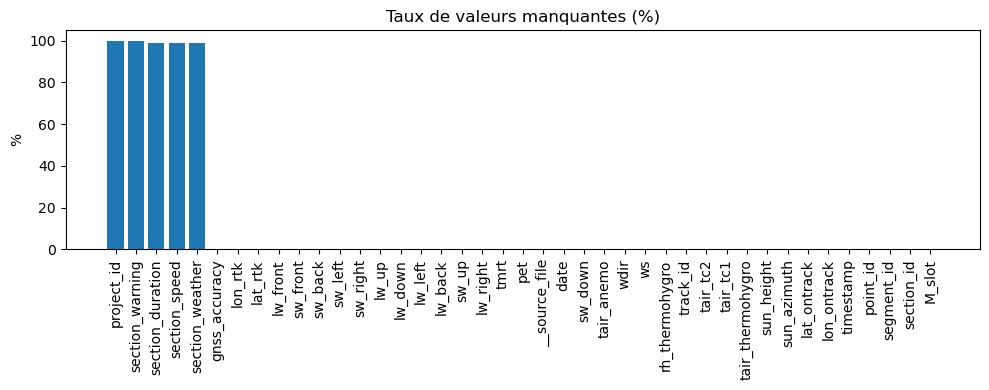

In [3]:
# Taux de valeurs manquantes
missing = raw.isna().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes :")
display(missing.head(20))

# Comptage global par parcours
print("Nombre de points par parcours :")
display(raw["track_id"].value_counts())

# Calcul du pourcentage de valeurs manquantes sur les variables météo
na = raw.isna().mean().sort_values(ascending=False) * 100

COMPT = FIG_DIR / "comptage"
fc.create_folder(COMPT)

# Visualisation graphique
plt.figure(figsize=(10, 4))
plt.bar(na.index, na.values)
plt.title("Taux de valeurs manquantes (%)")
plt.xticks(rotation=90)
plt.ylabel("%")
plt.tight_layout()
plt.savefig(COMPT/"na_pct_vars.png", dpi=150)
plt.show()

Les variables climatiques présentent très peu de valeurs manquantes, ce qui garantit une base de données fiable et exploitable.

Certaines colonnes pour les sections sont quasiment vides, ce qui est normal compte tenu de la configuration du jeu de données, et elles pourront donc être ignorées lors des analyses.

On observe également le nombre total de relevés par parcours, avec Écusson qui présente le volume le plus faible.

Le bloc suivant affiche une `heatmap` montrant le nombre d’échantillons collectés pour chaque combinaison `parcours × M_slot` (M1 à M4).  
Cela permet d’identifier les périodes ou parcours avec plus ou moins de données.

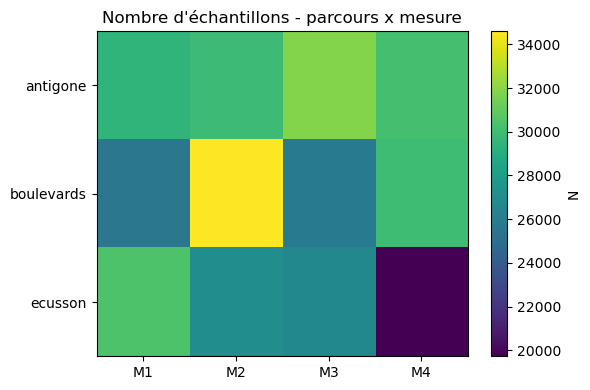

In [4]:
tab = (
    raw.dropna(subset=["track_id", "M_slot"])
       .pivot_table(
           index="track_id",
           columns="M_slot",
           values="timestamp",
           aggfunc="count",
           observed=True
       )
       .reindex(columns=["M1", "M2", "M3", "M4"])
       .fillna(0)
       .astype(int)
)

# Heatmap
plt.figure(figsize=(6, 4))
plt.imshow(tab.values, aspect="auto")
plt.xticks(range(tab.shape[1]), tab.columns)
plt.yticks(range(tab.shape[0]), tab.index)
plt.title("Nombre d'échantillons - parcours x mesure")
plt.colorbar(label="N")
plt.tight_layout()

# Sauvegarde et affichage
plt.savefig(COMPT/"heatmap_counts_parcours_M.png", dpi=150)
plt.show()

Le parcours `Antigone` possède le plus grand nombre de mesures sur l’ensemble des créneaux.

Le parcours `Boulevards` présente davantage de données sur le créneau M2 (midi), mais moins sur M3 (après-midi).
	
Le parcours `Écusson` contient globalement moins de mesures sur tous les créneaux.


# Pourquoi `Écusson` a moins de données ?

/var/folders/10/6m3y161n5d55p4d3x2g48d8c0000gn/T/ipykernel_1923/487929916.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])


,track_id,date_debut,date_fin,nb_jours,nb_passages,M1,M2,M3,M4
0,antigone,2024-10-29 08:36:30,2025-01-09 19:08:20,8,29,7,7,8,7
1,boulevards,2024-11-14 08:30:24,2025-01-16 19:26:41,7,23,5,7,5,6
2,ecusson,2024-10-31 08:30:13,2025-01-14 19:18:28,7,21,7,5,5,4


<Figure size 800x500 with 0 Axes>

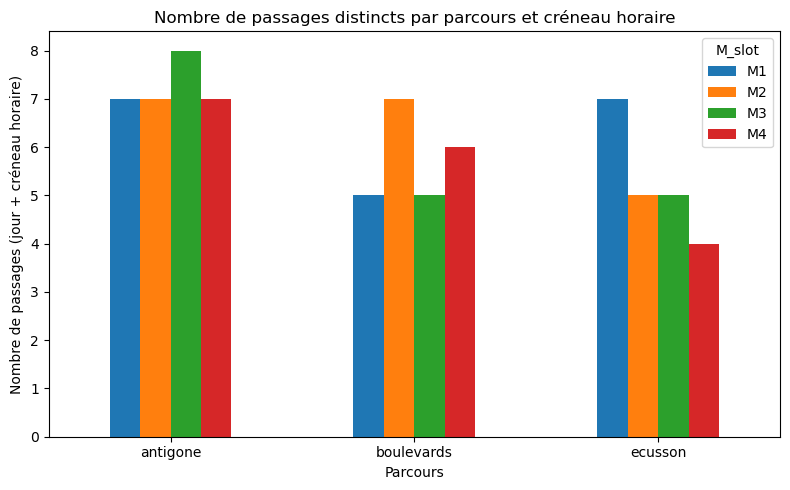

In [5]:
# Période de mesure et nombre de jours distincts
periode_parcours = (
    raw.dropna(subset=["track_id", "timestamp"])
       .groupby("track_id")
       .agg(
           date_debut=("timestamp", "min"),
           date_fin=("timestamp", "max"),
           nb_jours=("date", "nunique")
       )
       .reset_index()
)

# Nombre total de passages (jour + M_slot) par parcours
nb_passages_par_parcours = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby("track_id")[["date", "M_slot"]]
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
)

# Détail des passages par créneau horaire (M1, M2, M3, M4)
nb_passages_par_Mslot = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby(["track_id", "M_slot"])
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
       .pivot(index="track_id", columns="M_slot", values="nb_passages")
       .fillna(0)
       .astype(int)
)

# Fusion des résultats en un tableau unique
synthese_passages = (
    periode_parcours
    .merge(nb_passages_par_parcours, on="track_id", how="left")
    .merge(nb_passages_par_Mslot, on="track_id", how="left")
)

display(synthese_passages)

# Nombre de passages par parcours et créneau horaire
plt.figure(figsize=(8, 5))
nb_passages_par_Mslot.plot(
    kind="bar",
    figsize=(8, 5),
    rot=0,
    title="Nombre de passages distincts par parcours et créneau horaire"
)
plt.xlabel("Parcours")
plt.ylabel("Nombre de passages (jour + créneau horaire)")
plt.tight_layout()
plt.savefig(COMPT/"nb_passages_distincts_par_Mslot.png", dpi=150)
plt.show()

In [6]:
# Uniquement les fichiers liés à Écusson
paths_ecusson = sorted([p for p in DATA_DIR.rglob("*ecusson*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])

def get_dates_from_file(p):
    try:
        if p.suffix.lower() in (".xlsx", ".xls"):
            df = pd.read_excel(p)
        else:
            df = pd.read_csv(p, sep=None, engine="python")  # détection auto du séparateur
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
            return sorted(df["timestamp"].dropna().dt.date.unique())
        else:
            return []
    except Exception as e:
        print(f" Erreur lecture {p.name}: {e}")
        return []

file_dates = pd.DataFrame([
    {"fichier": p.name, "dates_trouvées": get_dates_from_file(p)}
    for p in paths_ecusson
])

display(file_dates)

# Combien de jours distincts au total :
all_dates = sorted({d for sublist in file_dates["dates_trouvées"] for d in sublist})
print(f"\n Nombre total de jours uniques mesurés pour le parcours Écusson : {len(all_dates)}")

/var/folders/10/6m3y161n5d55p4d3x2g48d8c0000gn/T/ipykernel_1923/2657569374.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/10/6m3y161n5d55p4d3x2g48d8c0000gn/T/ipykernel_1923/2657569374.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/10/6m3y161n5d55p4d3x2g48d8c0000gn/T/ipykernel_1923/2657569374.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/10/6m3y161n5d55p4d3x2

,fichier,dates_trouvées
0,picopatt_montpellier_ecusson_20241031_0827.csv,[2024-10-31]
1,picopatt_montpellier_ecusson_20241031_1127.csv,[2024-10-31]
2,picopatt_montpellier_ecusson_20241031_1425.csv,[2024-10-31]
3,picopatt_montpellier_ecusson_20241112_0830.csv,[2024-12-11]
4,picopatt_montpellier_ecusson_20241112_1124.csv,[2024-12-11]
5,picopatt_montpellier_ecusson_20241112_1430.csv,[2024-12-11]
6,picopatt_montpellier_ecusson_20241112_1723.csv,[2024-12-11]
7,picopatt_montpellier_ecusson_20241121_0832.csv,[2024-11-21]
8,picopatt_montpellier_ecusson_20241121_1729.csv,[2024-11-21]
9,picopatt_montpellier_ecusson_20241203_0829.csv,[2024-03-12]



 Nombre total de jours uniques mesurés pour le parcours Écusson : 7


Le parcours `Antigone` a bénéficié de la couverture la plus complète, tandis que `Écusson` présente le moins de passages. Cela s'explique par le fait qu'`Écusson` est bénéficié d'une journée de collecte de moins que `Antigone` et `Boulevards` 

In [7]:
df_ecusson = raw[raw["track_id"] == "ecusson"]
sections_lues = sorted(df_ecusson["section_id"].dropna().unique())

# Le parcours doit avoir 75 sections
sections_theoriques = list(range(1, 76))

# On cherche les manquantes
sections_manquantes = sorted(set(sections_theoriques) - set(sections_lues))

print("Nombre total attendu :", len(sections_theoriques))
print("Nombre réellement lus :", len(sections_lues))
print("Sections manquantes :", sections_manquantes)

Nombre total attendu : 75
Nombre réellement lus : 73
Sections manquantes : [12, 32]


Nous savons que le nombre de sections pour le parcours `Écusson` est de 73.

Les sections 12 et 32 sont manquantes dans tout les fichiers d'`Écusson`. 

# Statistiques descriptives sur les variables météo

Calcul des statistiques globales, par parcours et par créneau horaire sur les variables météorologiques présentes dans les données nettoyées (dossier `clean_nozeros` issue du notebook `NoZero.ipynb`).

In [8]:
DATA_NOZERO = Path("outputs/clean_nozeros")
bd = fc.load_all(DATA_NOZERO, False)

# Liste des variables météo présentes (sans sw_back et sw_down)
CANDIDATES = [
    "tair_thermohygro","tair_tc1","tair_tc2","tair_anemo",
    "rh_thermohygro","ws","wdir",
    "sw_up","sw_front","sw_right",
    "lw_up","lw_down","lw_front","lw_back","lw_left","lw_right",
    "tmrt","pet"
]
METEO = [c for c in CANDIDATES if c in bd.columns]
num_cols = [c for c in METEO if c != "wdir"]  # variables numériques classiques

# Résumé
print("Chargement terminé.")
print("Couverture :", bd['date'].min(), "->", bd['date'].max())
print("Parcours :", bd['track_id'].dropna().unique())
print("\nNombre de mesures par M_slot et parcours :")
print(
    bd.pivot_table(index="track_id", columns="M_slot", values="__source_file", aggfunc="count")
       .fillna(0)
       .astype(int)
)

Chargement terminé.
Couverture : 2024-10-29 -> 2025-01-16
Parcours : ['antigone' 'boulevards' 'ecusson']

Nombre de mesures par M_slot et parcours :
M_slot         M1     M2     M3     M4
track_id                              
antigone    29468  29924  31828  30237
boulevards  25603  34594  25785  29980
ecusson     30435  27041  26656  19730


In [9]:
stats_global = fc.summary_stats(bd, num_cols)
if "wdir" in METEO:
    stats_global.loc["wdir", "mean"] = fc.circular_mean_deg(bd["wdir"])

STATS = OUTPUT_DIR / "stats"
fc.create_folder(STATS)
stats_global.to_csv(STATS / "stats_global.xlsx")
display(stats_global)

,mean,std,min,p10,p25,median,p75,p90,max
tair_thermohygro,12.322580,4.446766,-0.971618,6.489281,9.496071,12.129015,15.034333,17.880903,25.053407
tair_tc1,20.773164,130.146941,0.007812,6.398438,9.359375,12.000000,15.023438,18.007812,2047.992188
tair_tc2,13.692911,53.698878,0.007812,6.515625,9.406250,11.976562,14.890625,17.929688,2047.992188
tair_anemo,14.543863,4.822161,1.000000,8.000000,11.000000,15.000000,17.000000,20.000000,30.000000
rh_thermohygro,60.532089,12.035269,37.474861,45.279850,51.145037,58.829862,69.543603,78.094377,87.657969
ws,1.054359,0.871207,0.102889,0.257222,0.463000,0.874555,1.388999,2.109220,11.009102
sw_up,66.664167,93.142589,0.000428,5.162209,13.390516,34.227502,73.292929,165.724752,712.930225
sw_front,54.993113,104.226845,3.323424,14.277620,15.882575,26.655764,47.904116,89.354224,984.895425
sw_right,57.173707,94.781859,2.769514,20.534338,21.522706,30.016879,49.817298,92.842337,957.943577
lw_up,363.435073,27.405188,266.539351,326.625260,346.569614,365.492545,381.343028,396.241645,457.708289


In [10]:
# Statistiques par parcours
track_code = {
    "antigone": "a",
    "boulevard": "b",
    "ecusson": "e"
}

by_track = []
for t, g in bd.groupby("track_id", dropna=True):
    s = fc.summary_stats(g, num_cols)
    if "wdir" in METEO:
        s.loc["wdir", "mean"] = fc.circular_mean_deg(g["wdir"])
    s = s.reset_index(names="variable")

    # Ajout de la lettre du parcours à chaque variable
    suffix = track_code.get(t, t[:1].lower())
    s["variable"] = s["variable"] + f"_{suffix}"

    by_track.append(s)

stats_by_track = pd.concat(by_track, ignore_index=True)
stats_by_track.to_csv(STATS / "stats_par_parcours.xlsx", index=False)
display(stats_by_track)

,variable,mean,std,min,p10,p25,median,p75,p90,max
0,tair_thermohygro_a,14.245584,4.113195,5.629435,9.148928,10.510796,14.585718,17.122530,19.531167,24.433890
1,tair_tc1_a,14.160871,4.162505,5.390625,8.957813,10.570312,14.429688,17.078125,19.304688,25.828125
2,tair_tc2_a,14.132794,4.132840,5.367188,9.015625,10.570312,14.359375,17.078125,19.304688,25.242188
3,tair_anemo_a,16.576262,4.666686,7.000000,11.000000,12.000000,16.000000,20.000000,23.000000,29.000000
4,rh_thermohygro_a,68.086875,11.272769,41.478447,52.453498,59.320058,67.802167,77.813993,83.217594,87.657969
5,ws_a,1.120058,0.931576,0.102889,0.257222,0.514444,0.874555,1.388999,2.212109,9.980214
6,sw_up_a,93.983147,104.843359,0.002999,14.830347,28.594182,56.454021,107.497082,252.223176,712.930225
7,sw_front_a,68.891622,112.767520,3.323424,14.268854,15.018739,36.552845,64.015032,133.100006,964.821644
8,sw_right_a,75.942238,118.619029,2.769514,20.474574,21.100284,40.956845,68.612144,142.063174,957.943577
9,lw_up_a,366.577550,28.594065,288.241808,327.358584,349.747293,367.960703,385.105986,403.606476,442.664544


In [11]:
# Statistiques par parcours et créneau horaire
by_mslot = []
for (t, mslot), g in bd.groupby(["track_id", "M_slot"], dropna=True):
    s = fc.summary_stats(g, num_cols)
    if "wdir" in METEO and "wdir" in g.columns:
        s.loc["wdir", "mean"] = fc.circular_mean_deg(g["wdir"])
    s = s.reset_index(names="variable")

    # Ajout du suffixe parcours + Mslot 
    # ex: 'v'_aM1
    suffix = track_code.get(t, t[:1].lower())
    s["variable"] = s["variable"] + f"_{suffix}{mslot}"

    by_mslot.append(s)

stats_track_M = pd.concat(by_mslot, ignore_index=True)

# Tri des variables par parcours et mslot
stats_track_M["sort_key"] = stats_track_M["variable"].str.extract(r"_(.M\d)").astype(str)
stats_track_M = stats_track_M.sort_values("variable").drop(columns="sort_key")

stats_track_M.to_csv(STATS / "stats_par_parcours_par_mesure.xlsx", index=False)
display(stats_track_M)

,variable,mean,std,min,p10,p25,median,p75,p90,max
12,lw_back_aM1,384.779002,19.699960,351.538890,360.811563,368.169548,381.446713,401.103398,416.322287,436.802259
30,lw_back_aM2,401.392051,20.743852,365.955424,375.464920,387.228131,396.302418,417.005842,430.818197,475.119119
48,lw_back_aM3,401.486580,21.018241,348.271464,373.868172,391.266271,398.757977,415.650105,433.582173,476.927509
66,lw_back_aM4,390.655730,19.413165,348.855602,368.780922,375.058050,387.528022,409.869671,418.217432,436.832678
84,lw_back_bM1,366.744207,12.466019,329.312336,351.067982,358.070420,367.089764,375.685884,383.389591,400.411764
...,...,...,...,...,...,...,...,...,...,...
131,ws_bM4,0.772245,0.488634,0.102889,0.102889,0.360111,0.720222,1.080332,1.440443,3.035220
149,ws_eM1,0.922397,0.727654,0.102889,0.102889,0.411555,0.771666,1.234666,1.800554,8.025326
167,ws_eM2,1.041472,0.793649,0.102889,0.180055,0.463000,0.874555,1.440443,2.109220,6.944994
185,ws_eM3,0.987694,0.745512,0.102889,0.180055,0.463000,0.823110,1.337554,1.954887,7.407994


# Matrices de corrélation par parcours

Affiche les `corrélations entre les variables météorologiques` pour chaque parcours.  

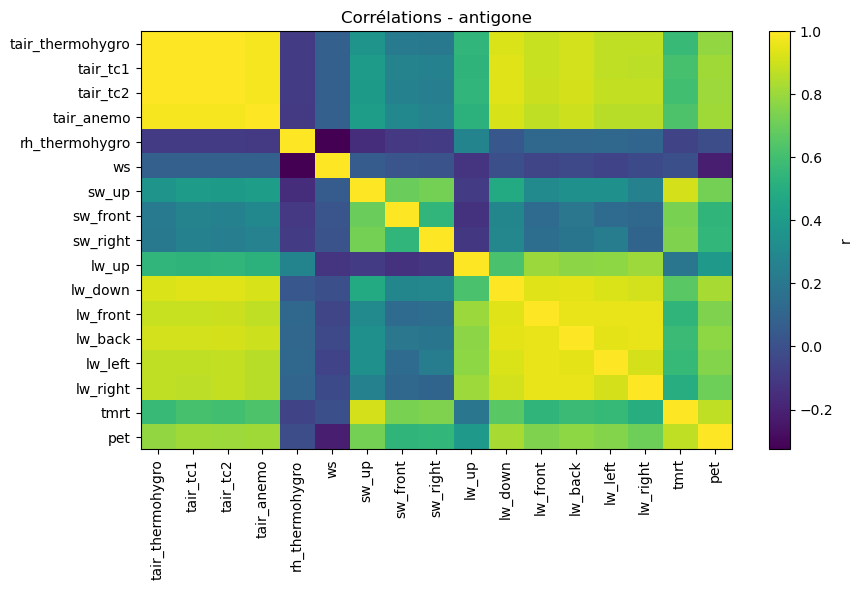

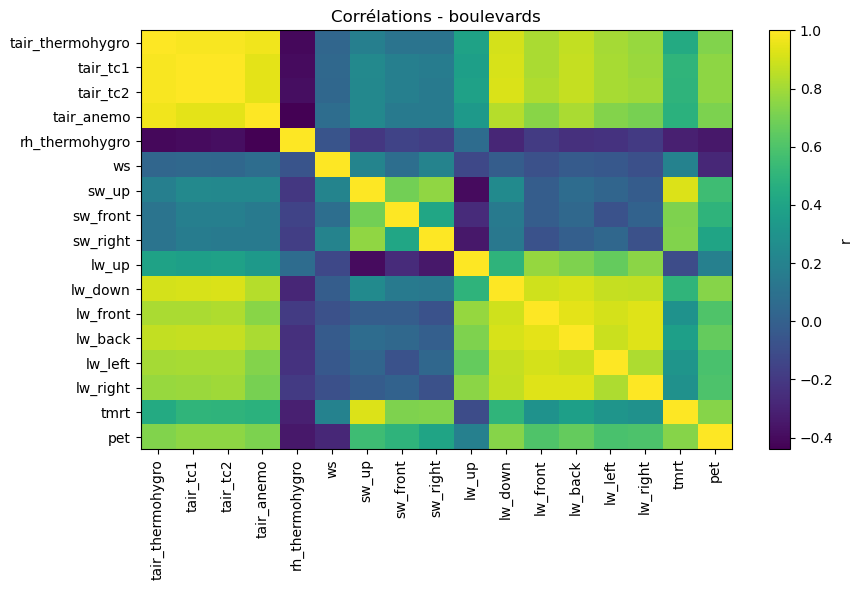

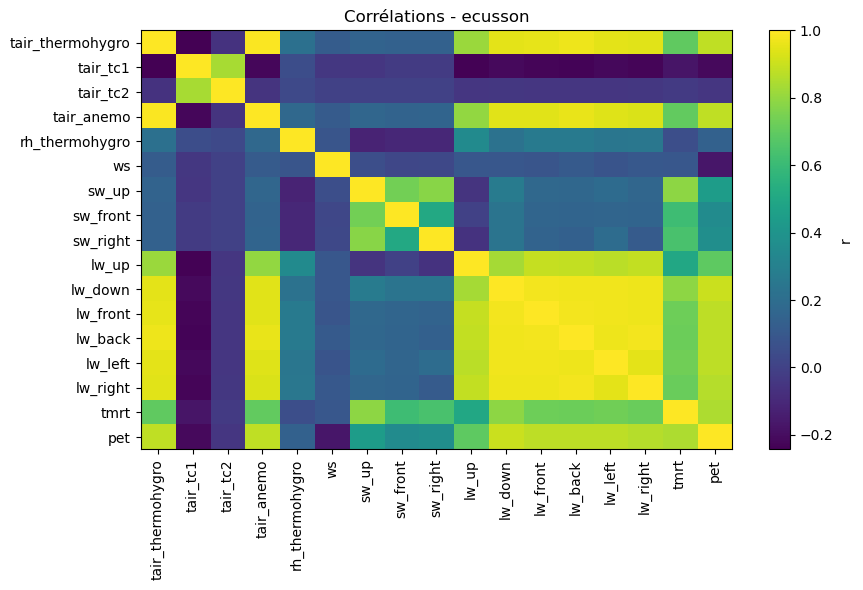

In [12]:
CORR = FIG_DIR / "correlation"
fc.create_folder(CORR)

for t, g in bd.groupby("track_id"):
    sel = g[num_cols].select_dtypes(include=[np.number]).dropna(how="all", axis=1)
    
    if sel.shape[1] < 2: 
        print(f"Parcours {t} : pas assez de colonnes numériques pour corrélation.")
        continue

    corr = sel.corr()

    plt.figure(figsize=(9, 6))
    plt.title(f"Corrélations - {t}")
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(label="r")
    plt.tight_layout()
    plt.savefig(CORR / f"corr_{t}.png", dpi=150)
    plt.show()

# Boxplots

Ce bloc affiche des `boxplots` pour comparer la distribution de chaques variables météorologiques clés entre les différents parcours .

/var/folders/10/6m3y161n5d55p4d3x2g48d8c0000gn/T/ipykernel_1923/3815769629.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 4))


<Figure size 700x400 with 0 Axes>

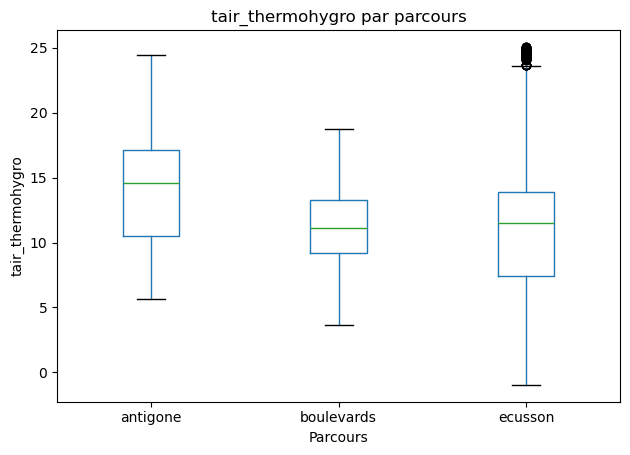

<Figure size 700x400 with 0 Axes>

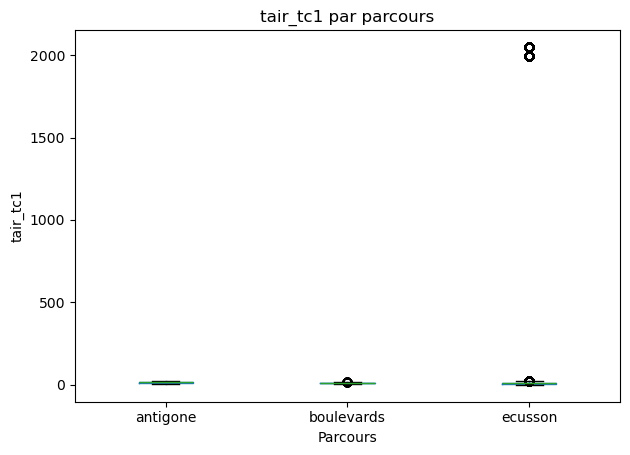

<Figure size 700x400 with 0 Axes>

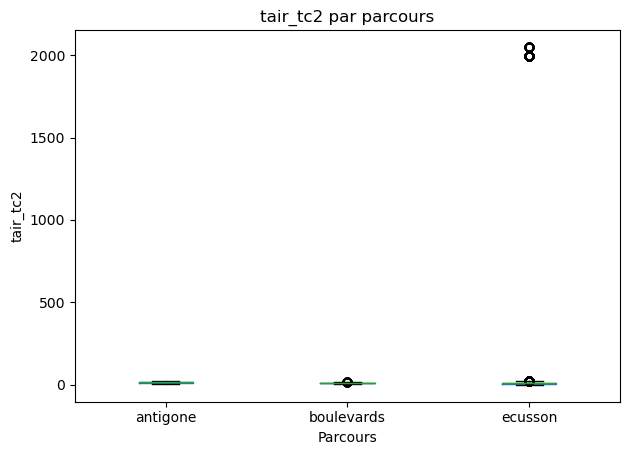

<Figure size 700x400 with 0 Axes>

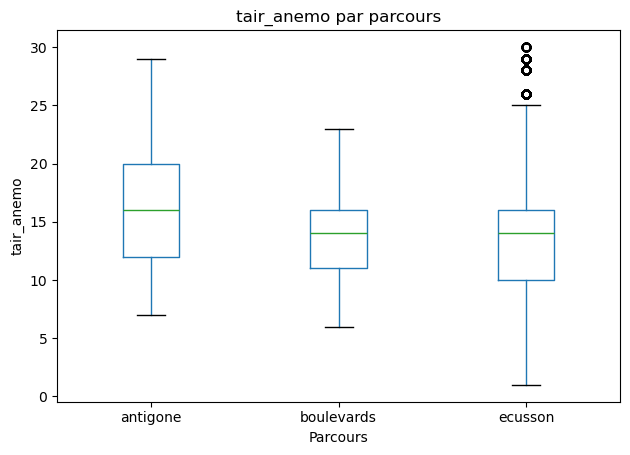

<Figure size 700x400 with 0 Axes>

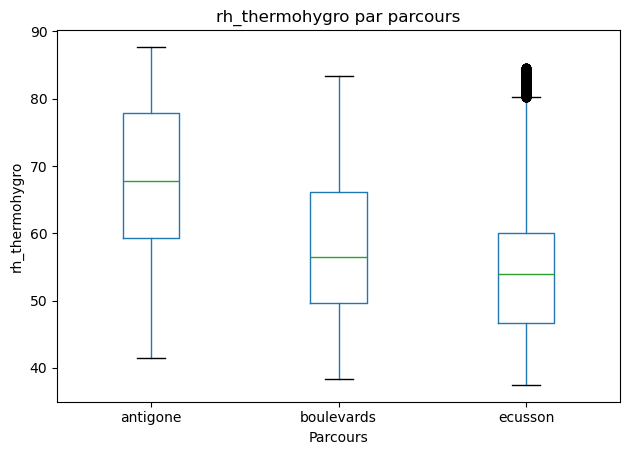

<Figure size 700x400 with 0 Axes>

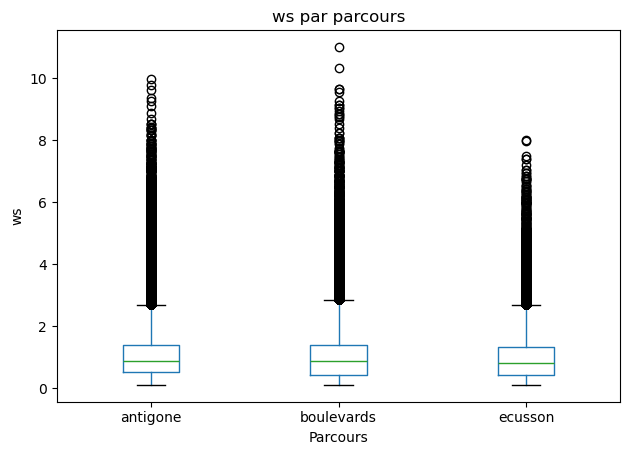

<Figure size 700x400 with 0 Axes>

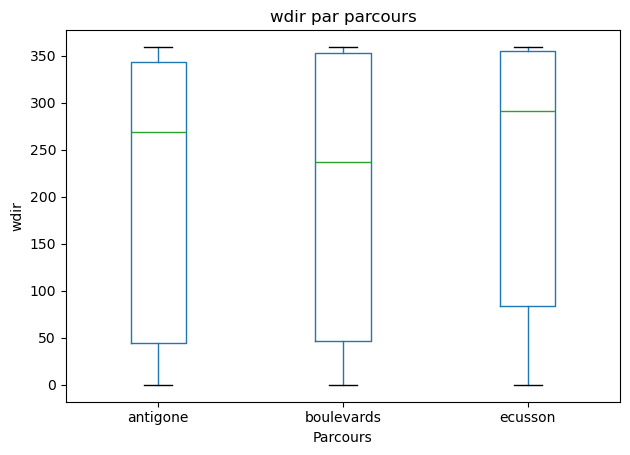

<Figure size 700x400 with 0 Axes>

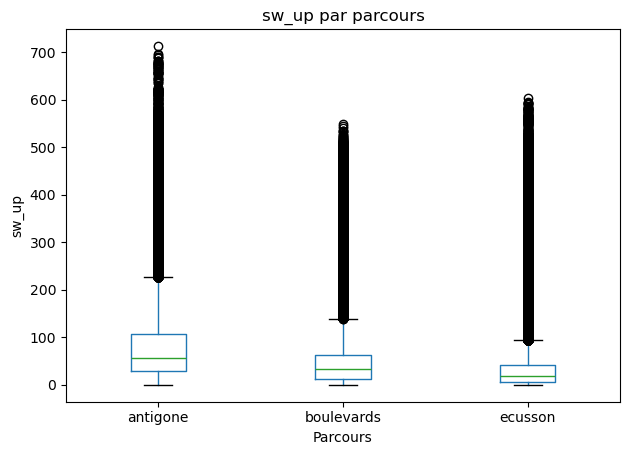

<Figure size 700x400 with 0 Axes>

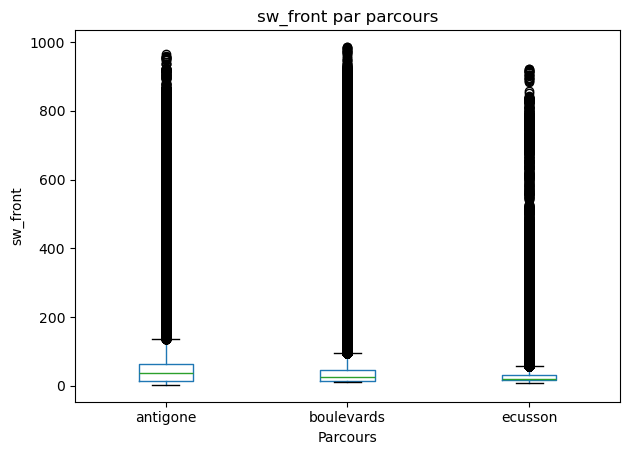

<Figure size 700x400 with 0 Axes>

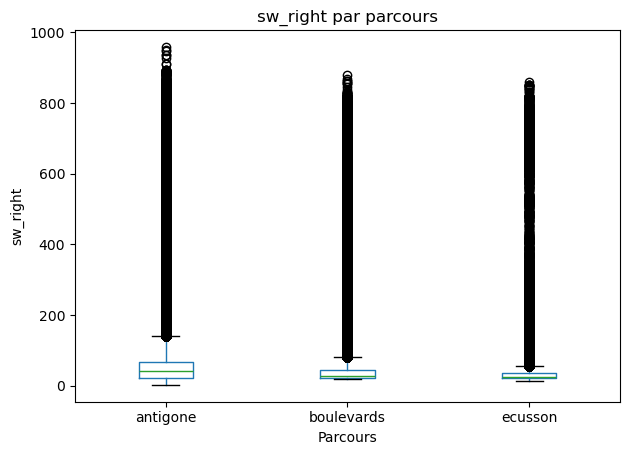

<Figure size 700x400 with 0 Axes>

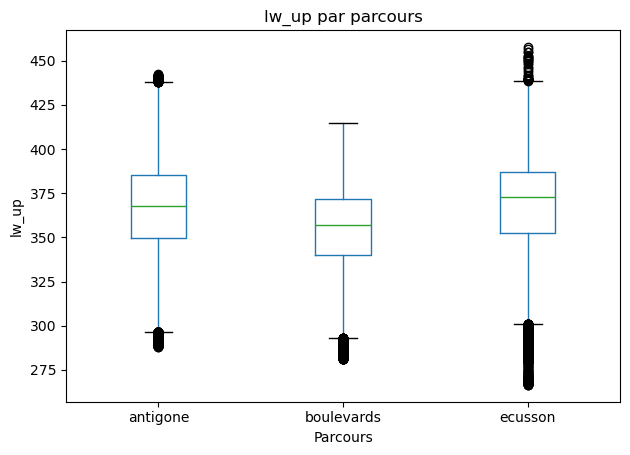

<Figure size 700x400 with 0 Axes>

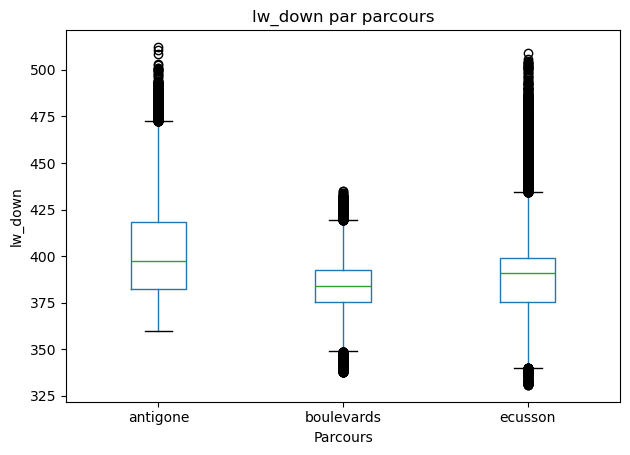

<Figure size 700x400 with 0 Axes>

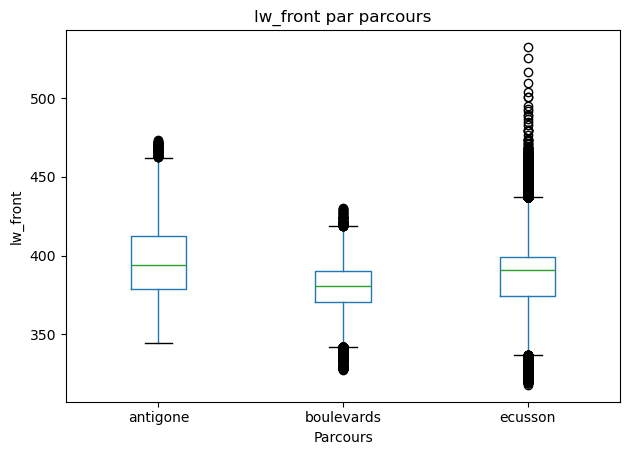

<Figure size 700x400 with 0 Axes>

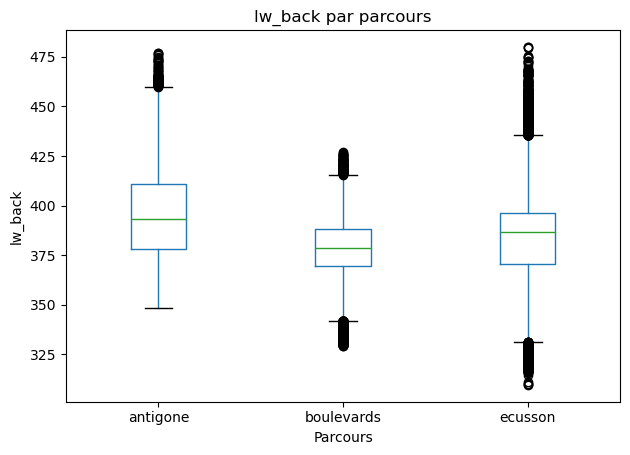

<Figure size 700x400 with 0 Axes>

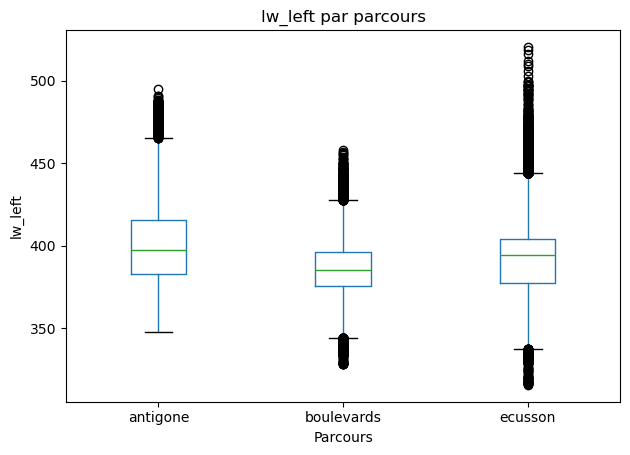

<Figure size 700x400 with 0 Axes>

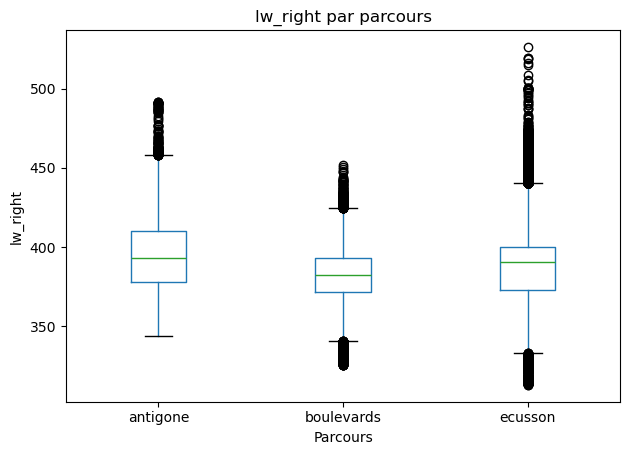

<Figure size 700x400 with 0 Axes>

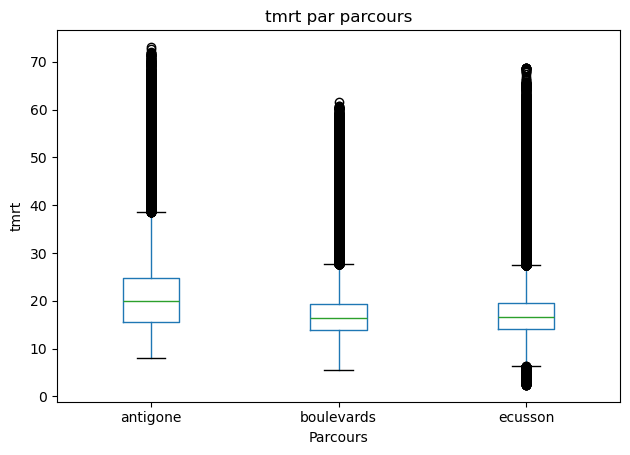

<Figure size 700x400 with 0 Axes>

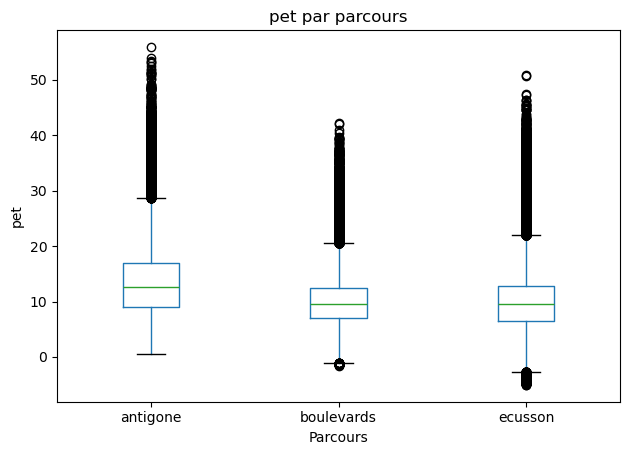

In [13]:
BOXPLOT = FIG_DIR / "boxplot"
fc.create_folder(BOXPLOT)
for v in METEO:
    plt.figure(figsize=(7, 4))
    bd.boxplot(column=v, by="track_id", grid=False)
    plt.title(f"{v} par parcours")
    plt.suptitle("")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()
    plt.savefig(BOXPLOT / f"box_{v}_parcours.png", dpi=150)

# Distribution globale des variables météo

Ce bloc trace un `histogramme` pour chaque variable météo, afin de visualiser la `répartition des valeurs mesurées` (et détecter d’éventuels biais ou valeurs extrêmes).

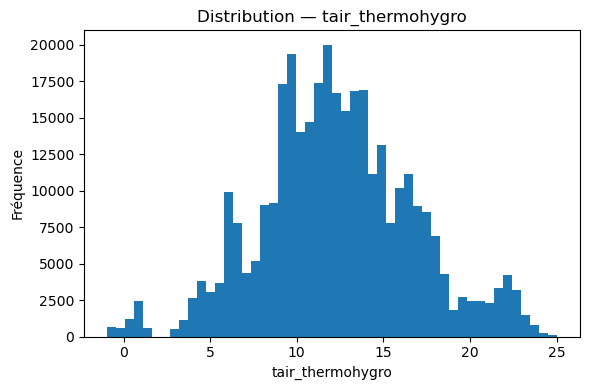

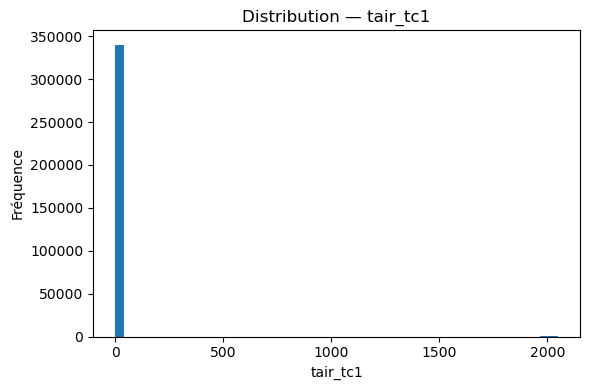

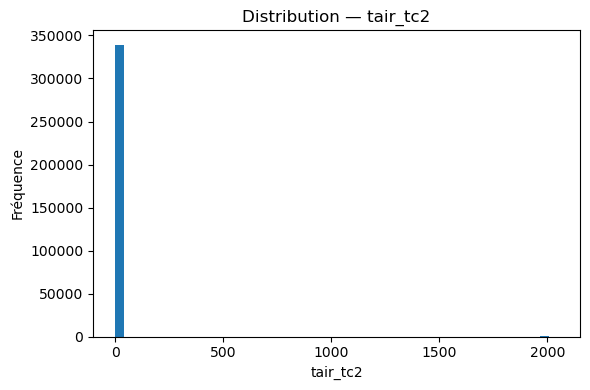

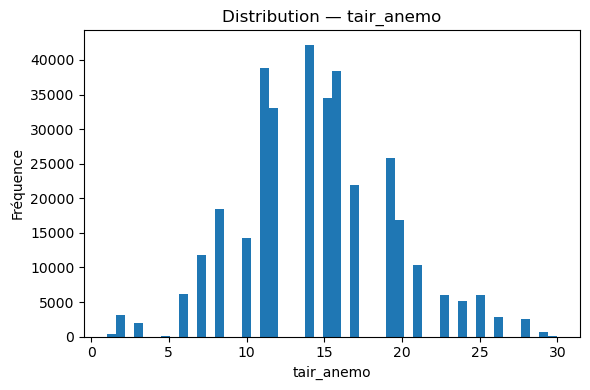

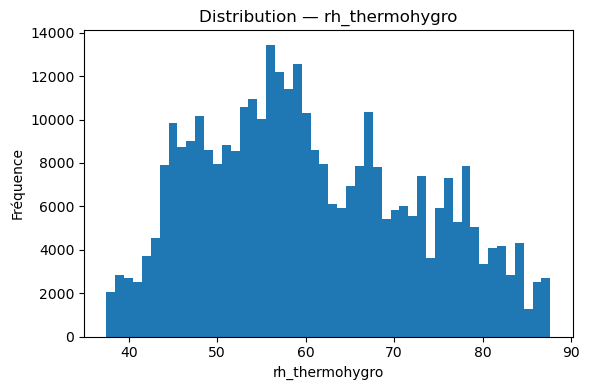

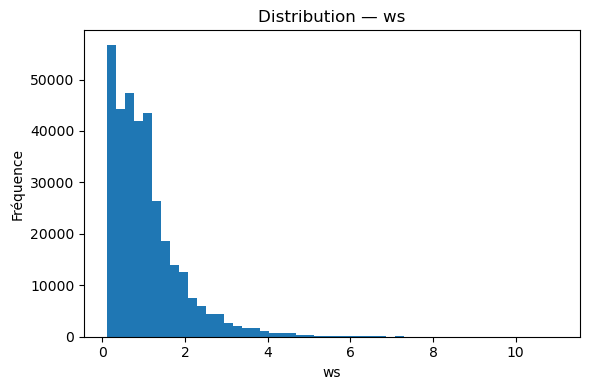

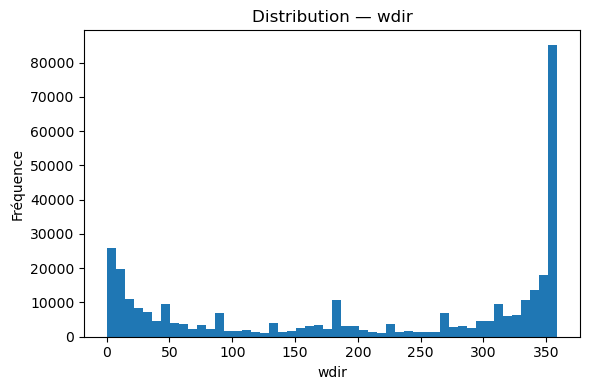

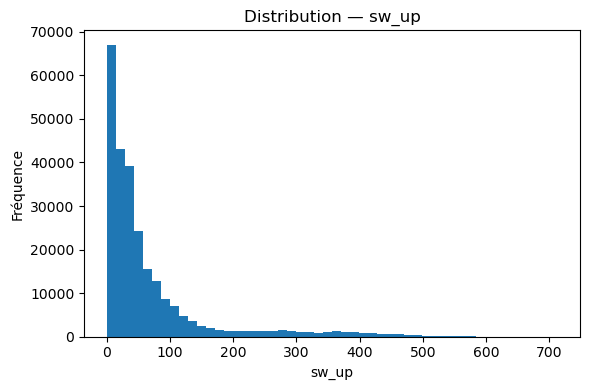

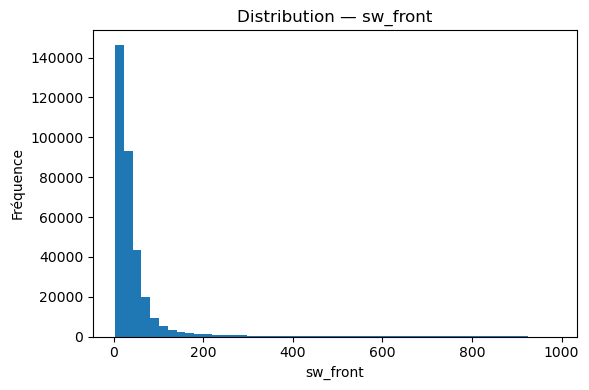

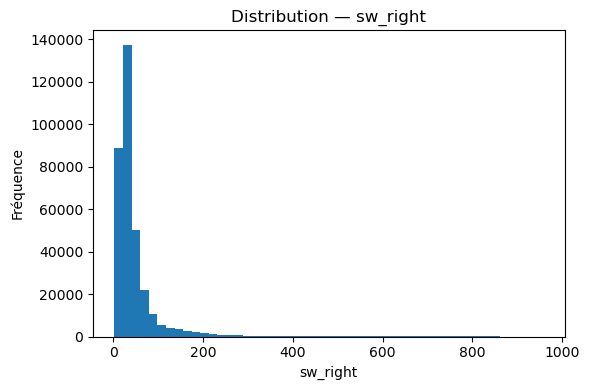

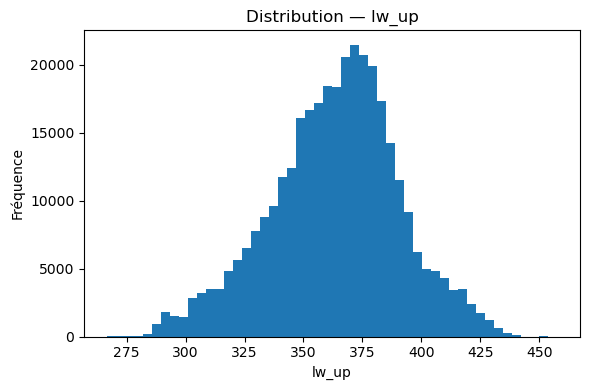

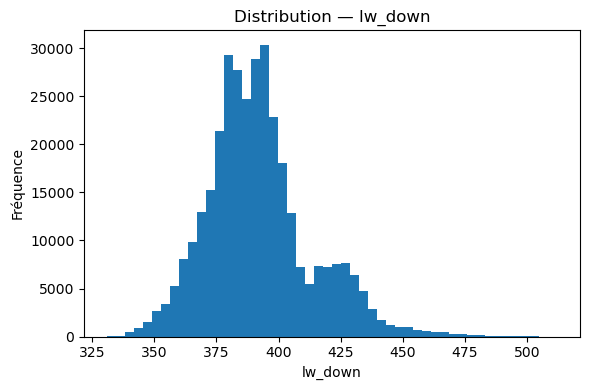

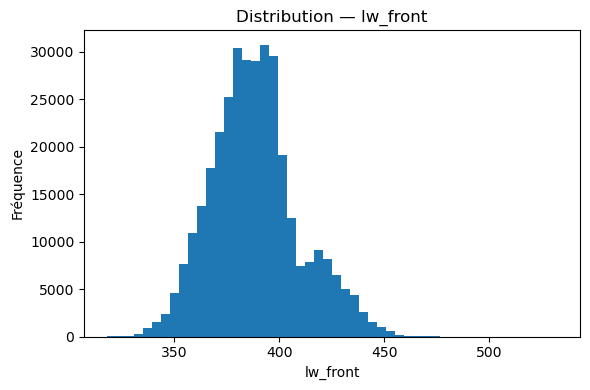

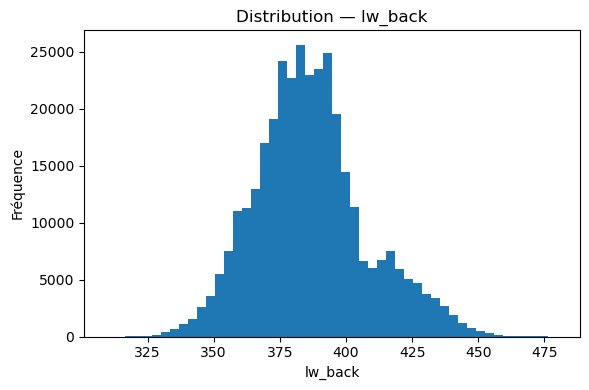

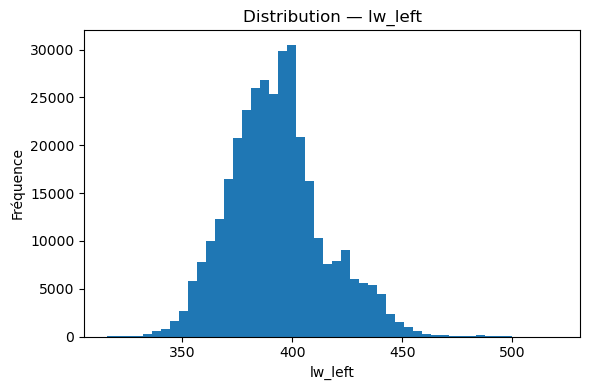

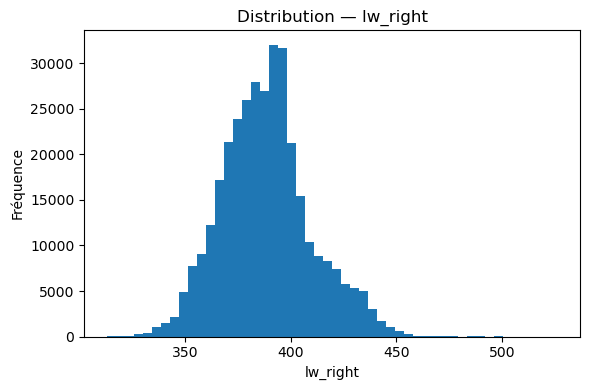

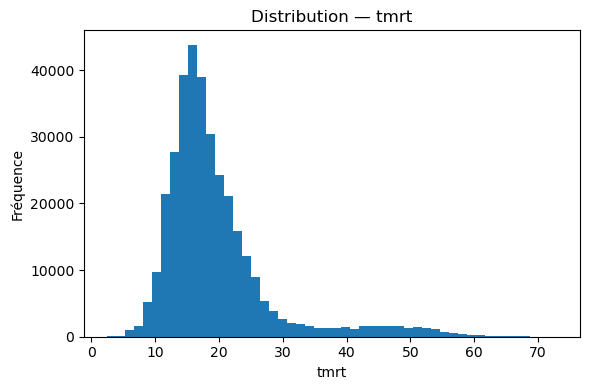

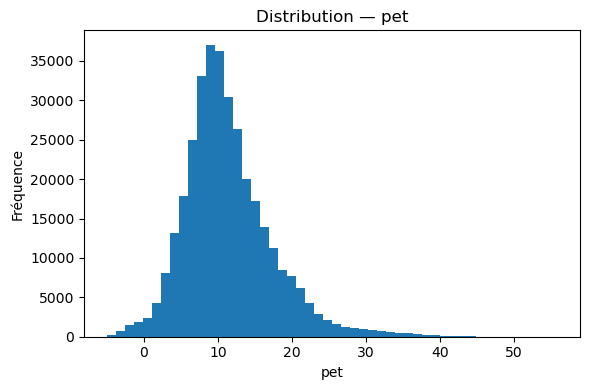

In [14]:
HIST = COMPT / "histogramme"
fc.create_folder(HIST)
for v in METEO:
    s = bd[v].dropna()
    if len(s) == 0:
        continue

    plt.figure(figsize=(6, 4))
    plt.hist(s, bins=50)
    plt.title(f"Distribution — {v}")
    plt.xlabel(v)
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.savefig(HIST / f"dist_global_{v}.png", dpi=150)

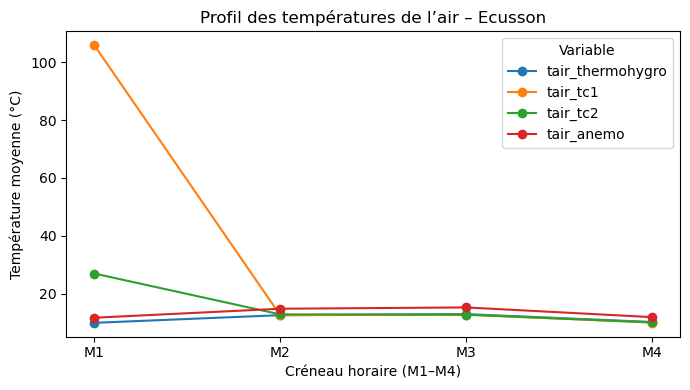

In [21]:
#########

PROFIL = FIG_DIR / "profil"
PROFIL.mkdir(parents=True, exist_ok=True)

order = ["M1", "M2", "M3", "M4"]

# Que sur Antigone
df_antigone = bd[bd["track_id"] == "ecusson"]

# Sélectionner les tair
TAIR = [c for c in METEO if c.startswith("tair_")]

# Calculer la moyenne par créneau
agg = df_antigone.groupby("M_slot")[TAIR].mean().reindex(order)

plt.figure(figsize=(7, 4))
for v in TAIR:
    plt.plot(order, agg[v], marker="o", label=v)

plt.title("Profil des températures de l’air – Ecusson")
plt.xlabel("Créneau horaire (M1–M4)")
plt.ylabel("Température moyenne (°C)")
plt.legend(title="Variable")
plt.tight_layout()
plt.savefig(PROFIL / "profil_tair_ecusson.png", dpi=150)
plt.show()


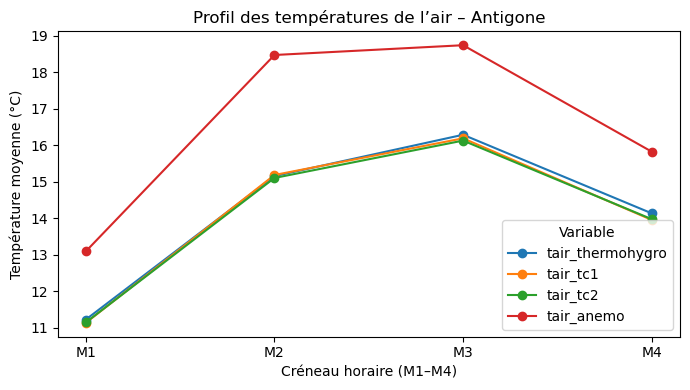

In [17]:
#########

PROFIL = FIG_DIR / "profil"
PROFIL.mkdir(parents=True, exist_ok=True)

order = ["M1", "M2", "M3", "M4"]

# Que sur Antigone
df_antigone = bd[bd["track_id"] == "antigone"]

# Sélectionner les tair
TAIR = [c for c in METEO if c.startswith("tair_")]

# Calculer la moyenne par créneau
agg = df_antigone.groupby("M_slot")[TAIR].mean().reindex(order)

plt.figure(figsize=(7, 4))
for v in TAIR:
    plt.plot(order, agg[v], marker="o", label=v)

plt.title("Profil des températures de l’air – Antigone")
plt.xlabel("Créneau horaire (M1–M4)")
plt.ylabel("Température moyenne (°C)")
plt.legend(title="Variable")
plt.tight_layout()
plt.savefig(PROFIL / "profil_tair_antigone.png", dpi=150)
plt.show()


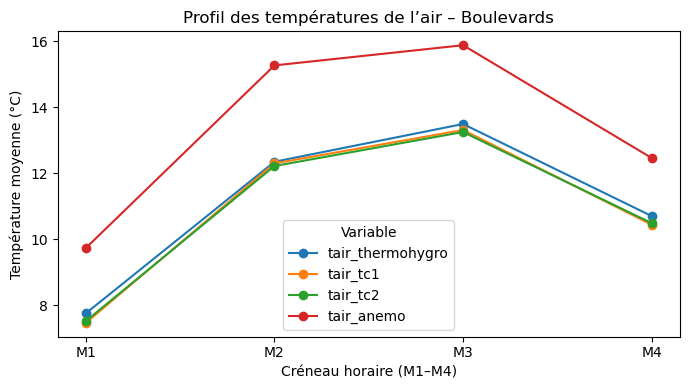

In [20]:
#########

PROFIL = FIG_DIR / "profil"
PROFIL.mkdir(parents=True, exist_ok=True)

order = ["M1", "M2", "M3", "M4"]

# Que sur Boulevards
df_antigone = bd[bd["track_id"] == "boulevards"]

# Sélectionner les tair
TAIR = [c for c in METEO if c.startswith("tair_")]

# Calculer la moyenne par créneau
agg = df_antigone.groupby("M_slot")[TAIR].mean().reindex(order)

plt.figure(figsize=(7, 4))
for v in TAIR:
    plt.plot(order, agg[v], marker="o", label=v)

plt.title("Profil des températures de l’air – Boulevards")
plt.xlabel("Créneau horaire (M1–M4)")
plt.ylabel("Température moyenne (°C)")
plt.legend(title="Variable")
plt.tight_layout()
plt.savefig(PROFIL / "profil_tair_boulevards.png", dpi=150)
plt.show()


# Profil des variables selon le moment de la journée (M1–M4)

Ce bloc trace, pour chaque variable météo et pour chaques parcours (`Antigone`, `Boulevards`, `Écusson`), l’évolution moyenne des valeurs selon les quatre créneaux horaires de mesure (`M1` à `M4`).

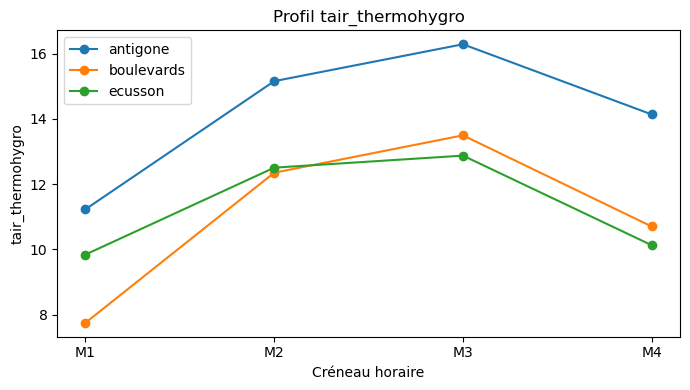

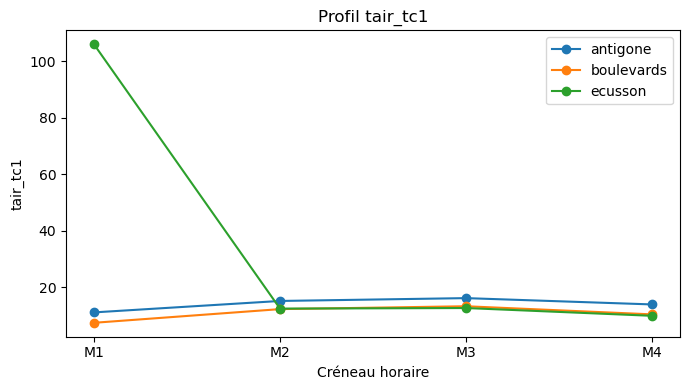

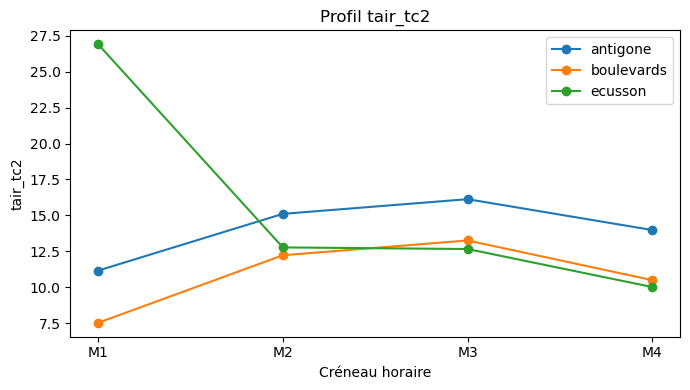

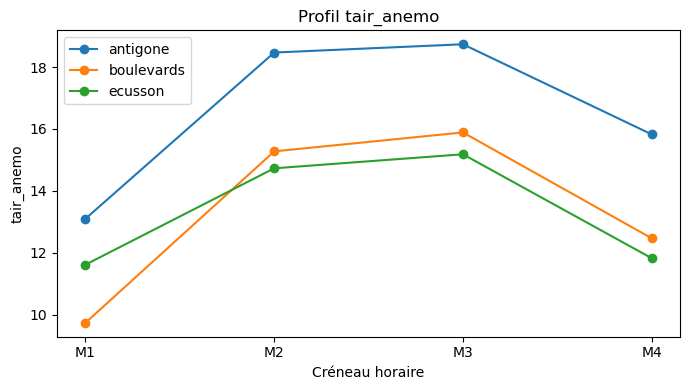

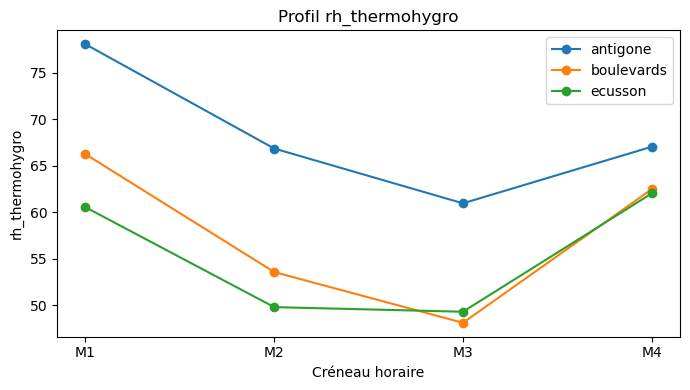

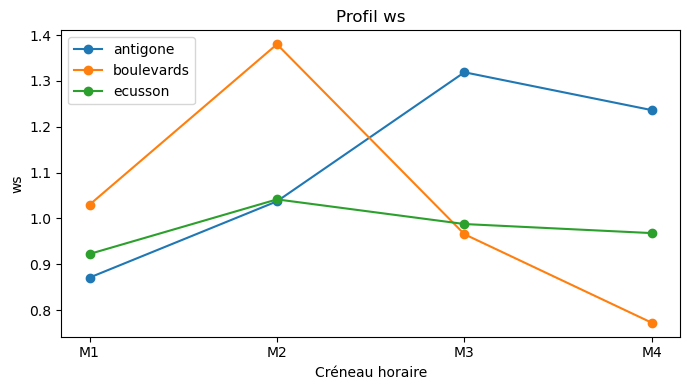

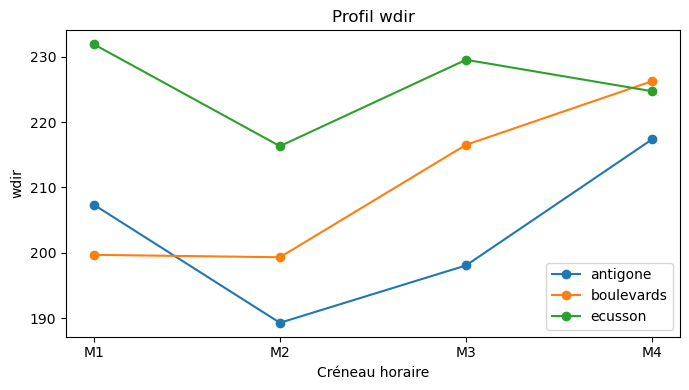

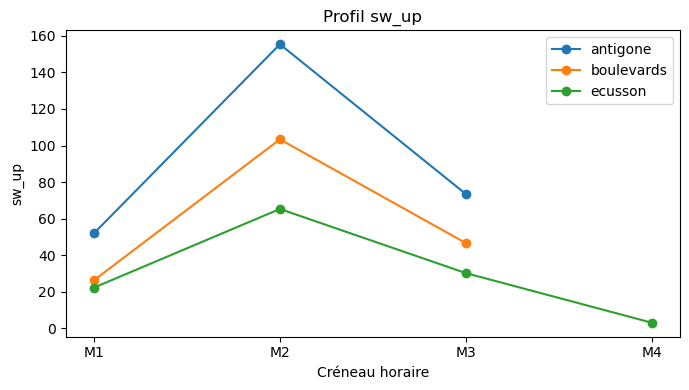

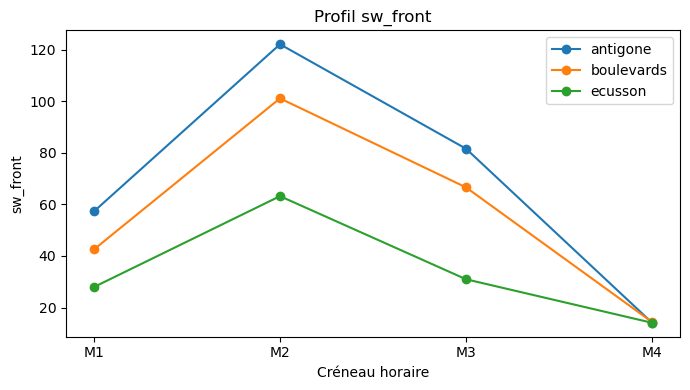

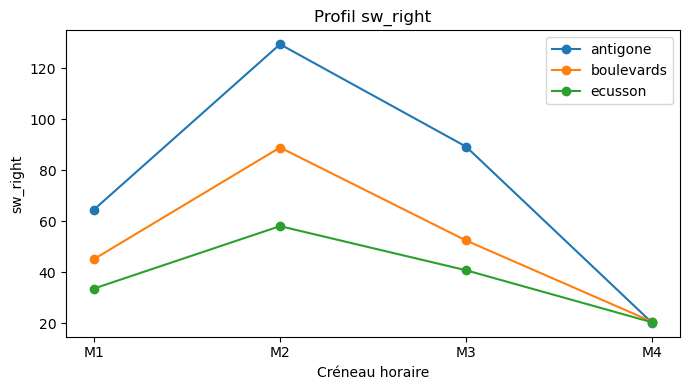

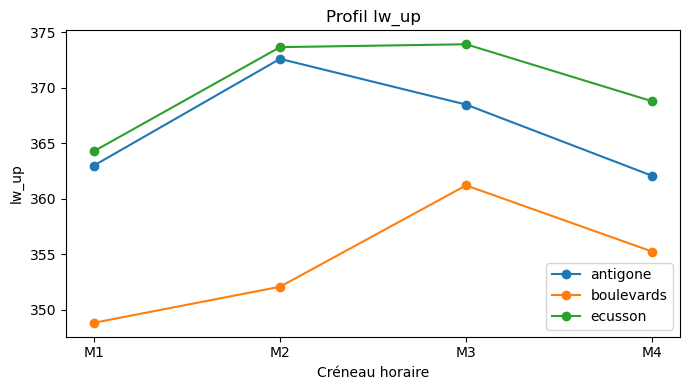

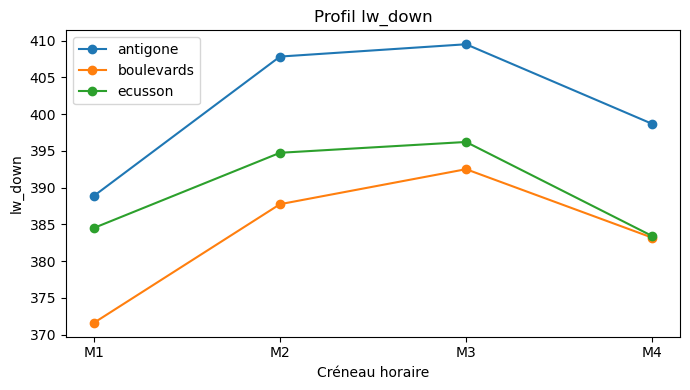

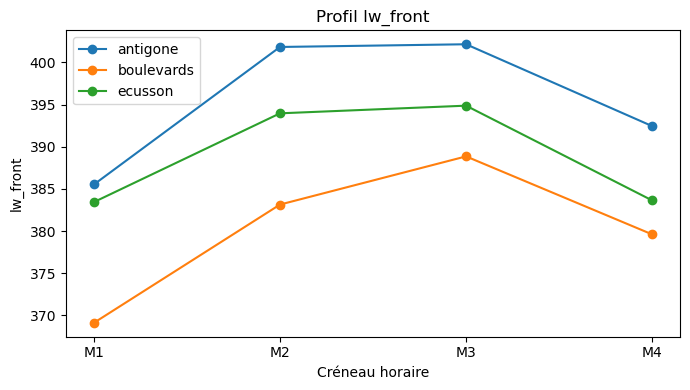

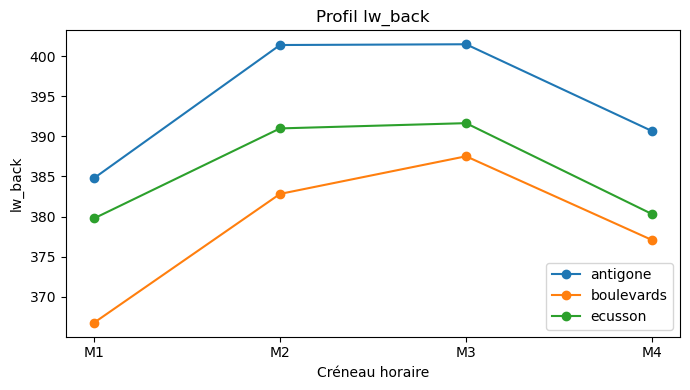

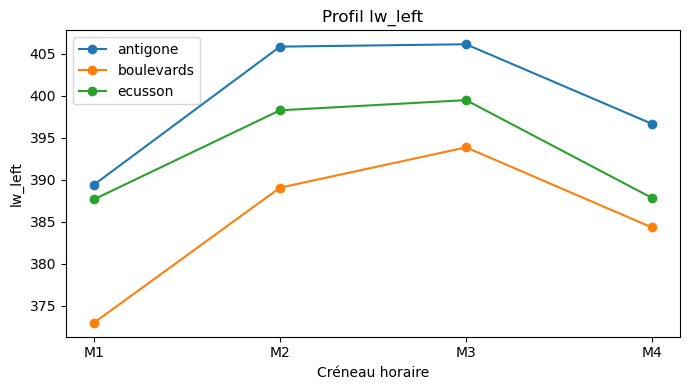

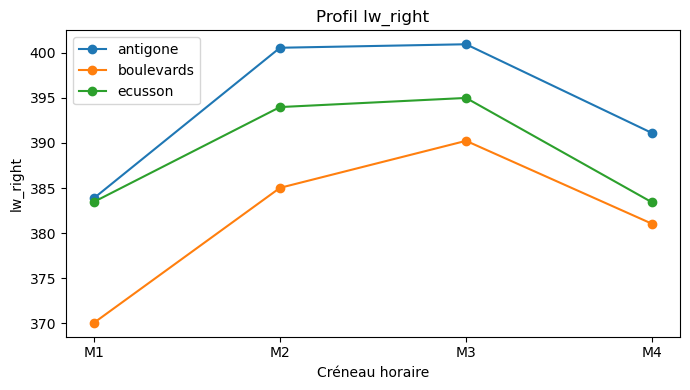

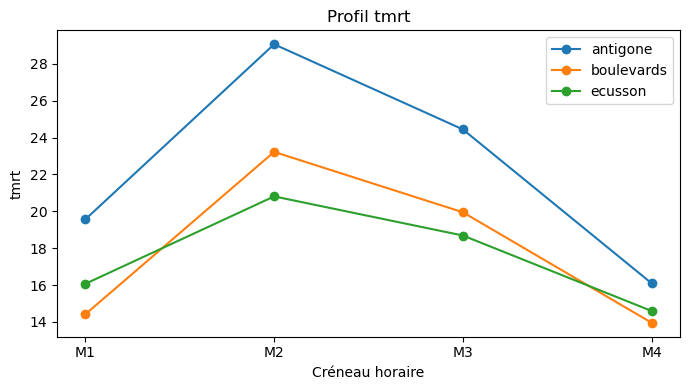

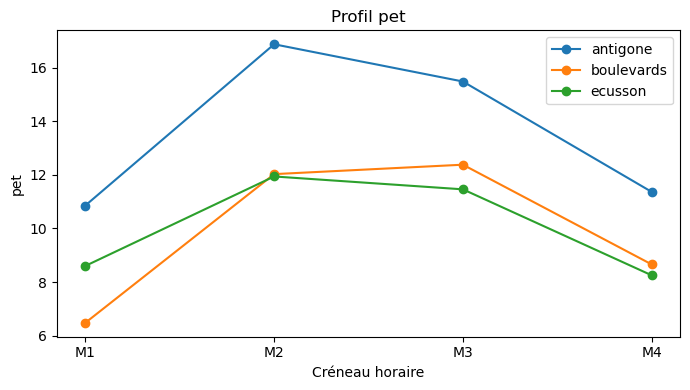

In [15]:
PROFIL = FIG_DIR / "profil"
fc.create_folder(PROFIL)

order = ["M1", "M2", "M3", "M4"]
agg = bd.groupby(["track_id", "M_slot"])[METEO].mean().reset_index()
tracks = ["antigone", "boulevards", "ecusson"]

for v in METEO:
    plt.figure(figsize=(7, 4))
    for t in tracks:
        gg = agg[agg.track_id == t].set_index("M_slot").reindex(order)[v]
        if gg.isna().all():
            continue
        plt.plot(order, gg.values, marker="o", label=t)
    
    plt.title(f"Profil {v}")
    plt.xlabel("Créneau horaire")
    plt.ylabel(v)
    plt.legend()
    plt.tight_layout()
    plt.savefig(PROFIL / f"profil_{v}_Mslots.png", dpi=150)

# Barmean des variables météo par parcours

Ce bloc compare la `moyenne des variables météorologiques` entre les trois parcours étudiés : `Antigone`, `Boulevards` et `Écusson`.

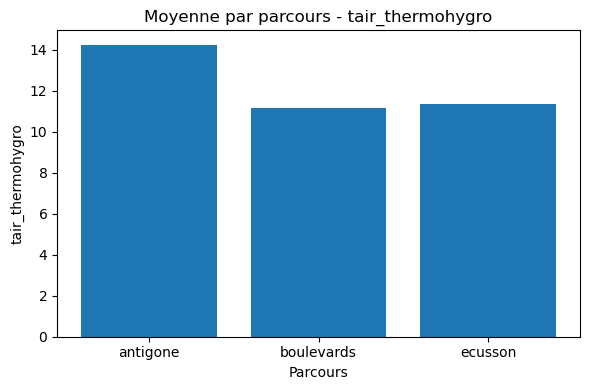

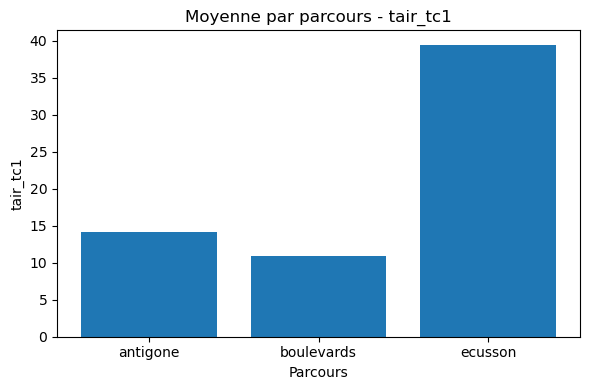

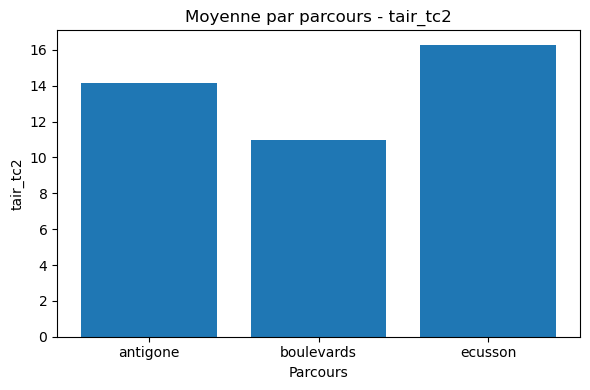

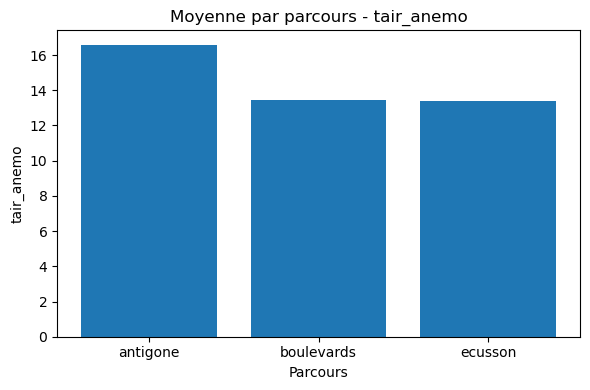

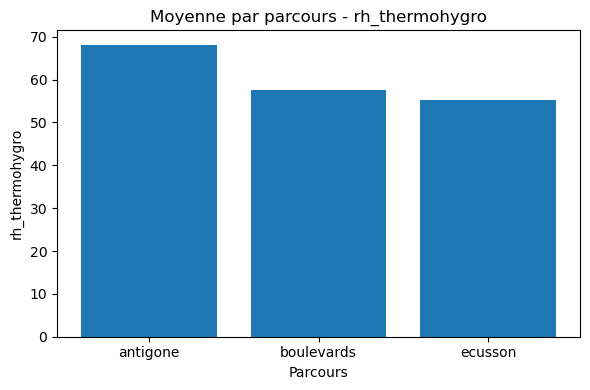

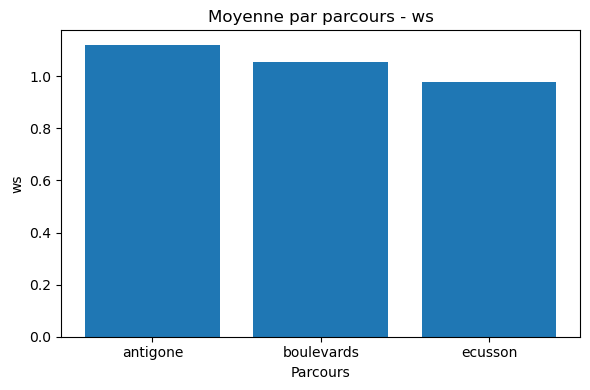

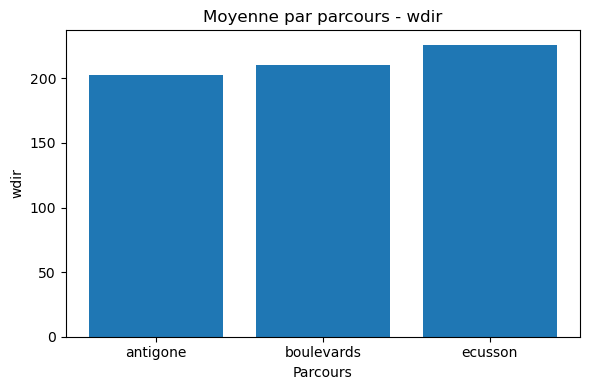

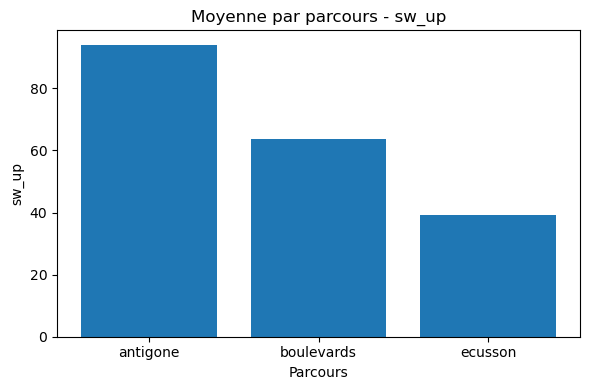

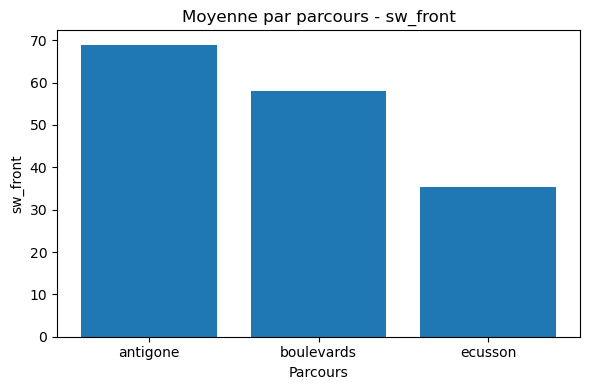

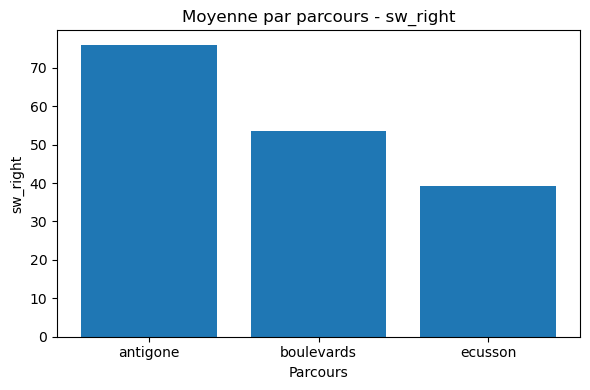

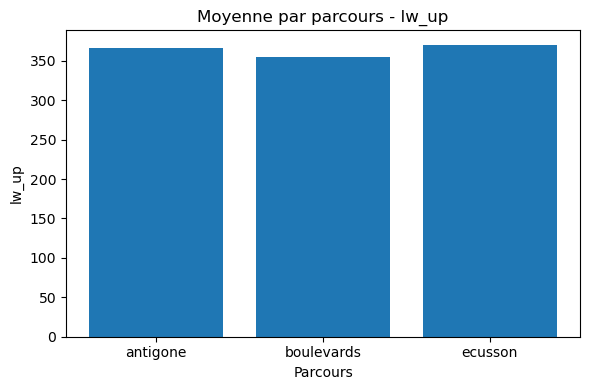

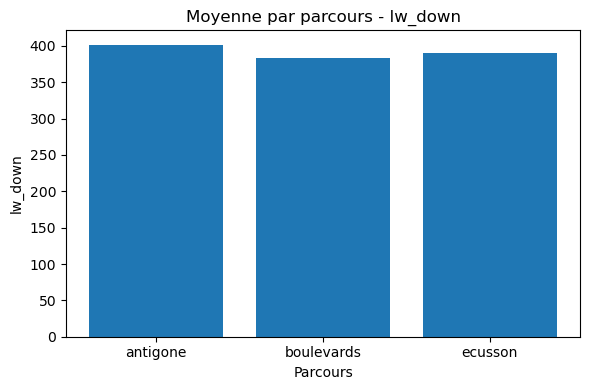

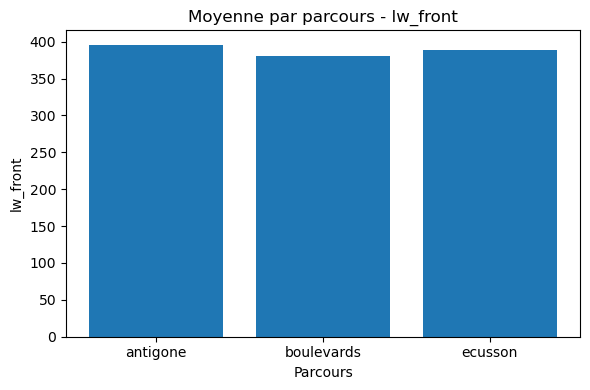

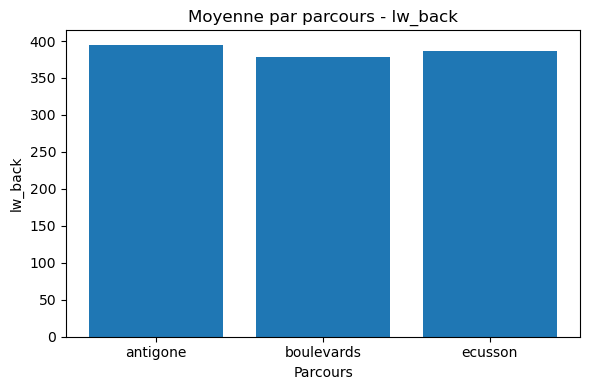

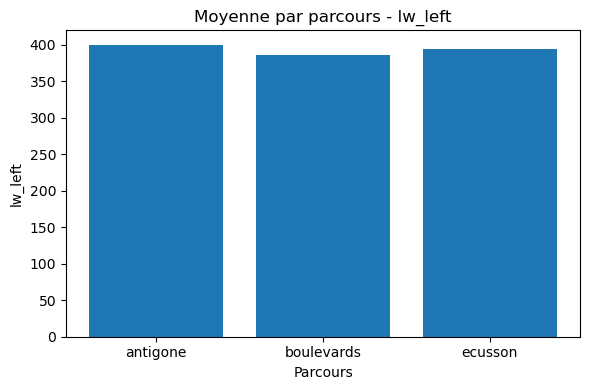

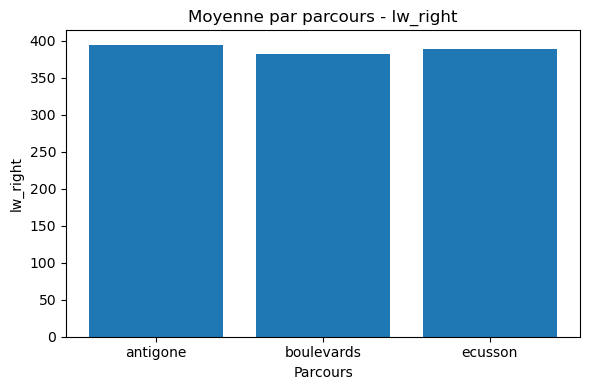

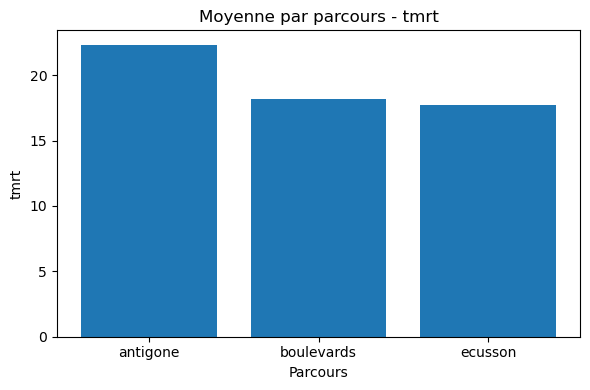

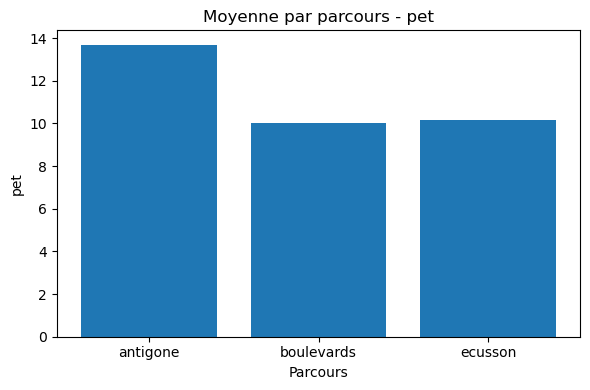

In [16]:
BARMEAN = FIG_DIR / "bar_mean"
fc.create_folder(BARMEAN)

comp = (bd[bd["track_id"].isin(["antigone", "boulevards", "ecusson"])]
          .groupby("track_id")[METEO]
          .mean()
          .T)

for v in comp.index:
    plt.figure(figsize=(6, 4))
    plt.bar(comp.columns.astype(str), comp.loc[v].values)
    plt.title(f"Moyenne par parcours - {v}")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()
    plt.savefig(BARMEAN / f"bar_mean_{v}_parcours.png", dpi=150)